# Import Libraries

In [ ]:
# %pip install -r requirements.txt

# Retrieve Dataset

In [1]:
from preprocess import retrieve_dataset, preprocess, to_np

(train_ds_raw, test_ds_raw), metadata = retrieve_dataset(should_shuffle_files=True)

train_ds = preprocess(train_ds_raw, {
  'is_filter_negative': True,
  'is_grayscale': False, 
  'is_downsample64': False,
  'is_downsample128': False, 
  'is_normalize': False,
})

test_ds = preprocess(test_ds_raw, {
  'is_filter_negative': True,
  'is_grayscale': False, 
  'is_downsample64': False, 
  'is_downsample128': False, 
  'is_normalize': False,
})

# Extract X_train, Y_train, X_test, Y_test

In [6]:
train_ds_numpy = to_np(train_ds)
test_ds_numpy = to_np(test_ds)

2021-10-24 18:50:34.066806: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [7]:
X_train = [example for example, label in train_ds_numpy]
y_train = [label for example, label in train_ds_numpy]

X_test = [example for example, label in test_ds_numpy]
y_test = [label for example, label in test_ds_numpy]

# Visualize Preprocessed Dataset

Length of X_train: 6672
Length of X_test: 1731


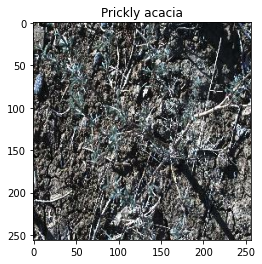

In [8]:
from visualize import visualize, compare

visualize(X_train[0], y_train[0], metadata)
print(f'Length of X_train: {len(X_train)}')
print(f'Length of X_test: {len(X_test)}')

# Perform Transfer Learning

In [8]:
from transfer_learning import init_conv_base, extract_features
conv_base = init_conv_base(X_train[0])

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [9]:
train_features, train_labels = extract_features(conv_base, X_train, y_train)  # Agree with our small dataset size
test_features, test_labels = extract_features(conv_base, X_test, y_test)

## Flatten To Feed into Different Algorithms

In [32]:
X_train_flatten = list(map(lambda x: x.flatten(), train_features))
y_train = train_labels
X_test_flatten = list(map(lambda x: x.flatten(), test_features))
y_test = test_labels

print(train_labels.shape)
print("feature size now:", X_train[0].shape) # orginal feature is of dimension 196608

(6672,)
feature size now: (256, 256, 3)


In [29]:
# For KNN, K Fold is just to look at prediction across various sets of data
# X_full = list(X_train_flatten)
# X_full.append(X_test_flatten)
# y_full = list(y_train)
# y_full.append(list(y_test))

# print(len(X_full))
# print(len(y_full))

6678
6672


# Test SVM Model with K-Fold Validation

In [ ]:
from run_algo_with_kfold import kfold_cross_validation

kernels = ['linear', 'rbf', 'poly', 'sigmoid']
k = 5
final_accuracies = []
for kernel in kernels:
  final_accuracy = kfold_cross_validation(k, X_train_flatten, y_train, 'knn', {'kernel': kernel})
  final_accuracies.append(final_accuracy)

Running 5-fold cross validation for knn with {'n_neighbors': 5}
Obtained split accuracy of: 0.4779026217228464
Obtained split accuracy of: 0.5056179775280899
Obtained split accuracy of: 0.5179910044977512
Obtained split accuracy of: 0.5067466266866567
Obtained split accuracy of: 0.512743628185907
Completed 5-fold cross validation for knn with {'n_neighbors': 5}
Obtained average accuracy of: 0.5042003717242503
Running 5-fold cross validation for knn with {'n_neighbors': 5}
Obtained split accuracy of: 0.4779026217228464
Obtained split accuracy of: 0.5056179775280899
Obtained split accuracy of: 0.5179910044977512


In [ ]:
print(final_accuracies)